# Kfold-finetune

https://www.kaggle.com/shaojiaxin/u-net-with-simple-resnet-blocks-v2-new-loss

## import

In [1]:
import os
import sys
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

%matplotlib inline

# import cv2
from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img#,save_img
from keras.callbacks import CSVLogger

D:\Anaconda2\envs\py3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## loss & metric

In [4]:
from __future__ import print_function, division

# code download from: https://github.com/bermanmaxim/LovaszSoftmax
def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
    return jaccard


# --------------------------- BINARY LOSSES ---------------------------

def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        def treat_image(log_lab):
            log, lab = log_lab
            log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
            log, lab = flatten_binary_scores(log, lab, ignore)
            return lovasz_hinge_flat(log, lab)
        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
        loss = tf.reduce_mean(losses)
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """

    def compute_loss():
        labelsf = tf.cast(labels, logits.dtype)
        signs = 2. * labelsf - 1.
        errors = 1. - logits * tf.stop_gradient(signs)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort")
        gt_sorted = tf.gather(labelsf, perm)
        grad = lovasz_grad(gt_sorted)
        # loss = tf.tensordot(tf.nn.relu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        
        loss = tf.reduce_sum(tf.multiply(tf.nn.relu(errors_sorted), tf.stop_gradient(grad), name="loss_non_void"))
        return loss

    # deal with the void prediction case (only void pixels)
    loss = tf.cond(tf.equal(tf.shape(logits)[0], 0),
                   lambda: tf.reduce_sum(logits) * 0.,
                   compute_loss,
                   strict=True,
                   name="loss"
                   )
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = tf.reshape(scores, (-1,))
    labels = tf.reshape(labels, (-1,))
    if ignore is None:
        return scores, labels
    valid = tf.not_equal(labels, ignore)
    vscores = tf.boolean_mask(scores, valid, name='valid_scores')
    vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
    return vscores, vlabels

def lovasz_loss(y_true, y_pred):
    y_true, y_pred = K.cast(K.squeeze(y_true, -1), 'int32'), K.cast(K.squeeze(y_pred, -1), 'float32')
    #logits = K.log(y_pred / (1. - y_pred))
    logits = y_pred #Jiaxin
    loss = lovasz_hinge(logits, y_true, per_image = True, ignore = None)
    return loss

In [24]:
"""
Lovasz-Softmax and Jaccard hinge loss in Tensorflow
Maxim Berman 2018 ESAT-PSI KU Leuven (MIT License)
"""

from __future__ import print_function, division

import tensorflow as tf
import numpy as np


def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
    return jaccard


# --------------------------- BINARY LOSSES ---------------------------


def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        def treat_image(log_lab):
            log, lab = log_lab
            log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
            log, lab = flatten_binary_scores(log, lab, ignore)
            return lovasz_hinge_flat(log, lab)
        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
        loss = tf.reduce_mean(losses)
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """

    def compute_loss():
        labelsf = tf.cast(labels, logits.dtype)
        signs = 2. * labelsf - 1.
        errors = 1. - logits * tf.stop_gradient(signs)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort")
        gt_sorted = tf.gather(labelsf, perm)
        grad = lovasz_grad(gt_sorted)
        # loss = tf.tensordot(tf.nn.relu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        # loss = tf.reduce_sum(tf.multiply(tf.nn.relu(errors_sorted), tf.stop_gradient(grad), name="loss_non_void"))
        loss = tf.reduce_sum(tf.multiply(tf.nn.relu(errors_sorted), tf.stop_gradient(grad), name="loss_non_void"))
        return loss

    # deal with the void prediction case (only void pixels)
    loss = tf.cond(tf.equal(tf.shape(logits)[0], 0),
                   lambda: tf.reduce_sum(logits) * 0.,
                   compute_loss,
                   strict=True,
                   name="loss"
                   )
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = tf.reshape(scores, (-1,))
    labels = tf.reshape(labels, (-1,))
    if ignore is None:
        return scores, labels
    valid = tf.not_equal(labels, ignore)
    vscores = tf.boolean_mask(scores, valid, name='valid_scores')
    vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
    return vscores, vlabels

In [29]:
def get_iou_vector(A, B):
    batch_size = A.shape[0]
    metric = []
    for batch in range(batch_size):
        t, p = A[batch]>0, B[batch]>0
#         if np.count_nonzero(t) == 0 and np.count_nonzero(p) > 0:
#             metric.append(0)
#             continue
#         if np.count_nonzero(t) >= 1 and np.count_nonzero(p) == 0:
#             metric.append(0)
#             continue
#         if np.count_nonzero(t) == 0 and np.count_nonzero(p) == 0:
#             metric.append(1)
#             continue
        
        intersection = np.logical_and(t, p)
        union = np.logical_or(t, p)
        iou = (np.sum(intersection > 0) + 1e-10 )/ (np.sum(union > 0) + 1e-10)
        thresholds = np.arange(0.5, 1, 0.05)
        s = []
        for thresh in thresholds:
            s.append(iou > thresh)
        metric.append(np.mean(s))

    return np.mean(metric)

def my_iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred > 0], tf.float64)

def my_iou_metric_2(label, pred):
    return tf.py_func(get_iou_vector, [label, pred > .45], tf.float64)

## data

In [7]:
# Set some parameters
img_size_ori = 101
img_size_target = 101
im_width = 101
im_height = 101
im_chan = 1
basicpath = './data/'
path_train = basicpath + 'train/'
path_test = basicpath + 'test/'

path_train_images = path_train + 'images/'
path_train_masks = path_train + 'masks/'
path_test_images = path_test + 'images/'

In [8]:
# Loading of training/testing ids and depths

train_df = pd.read_csv("./data/train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("./data/depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

len(train_df)

4000

In [9]:
train_df["images"] = [np.array(load_img("./data/train/images/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

In [10]:
train_df["masks"] = [np.array(load_img("./data/train/masks/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

In [11]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)

def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

D:\Anaconda2\envs\py3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


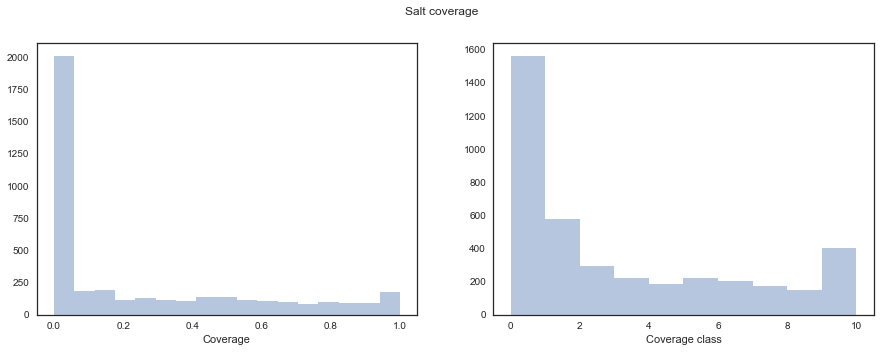

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_df.coverage, kde=False, ax=axs[0])
sns.distplot(train_df.coverage_class, bins=10, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")
plt.show()

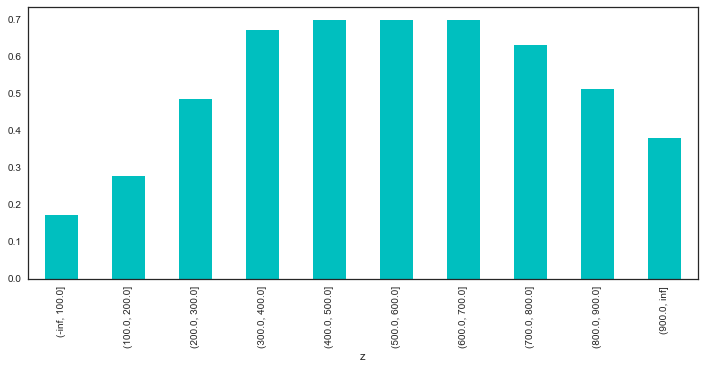

In [13]:
z_cut = pd.cut(train_df.z, [-np.Inf, 100, 200, 300, 400, 500, 600, 700, 800, 900, np.Inf])
c_cut = pd.cut(train_df.coverage, [-np.Inf, 0.0, .1, .2, .3, .4, .5, .6, .7, .8, .9, np.Inf], labels=range(11))
train_df["c1"] = (train_df.coverage > 0).astype("int")
train_df["z_cut"] = z_cut
train_df["c_cut"] = c_cut

z_group = train_df.groupby(z_cut)
(z_group.c1.sum() / z_group.c1.size()).plot(kind="bar", color="c", figsize=(12, 5))
plt.show()

## 5fold-split --seed 123

In [14]:
from sklearn.model_selection import StratifiedKFold

X = np.array(train_df.images.tolist()).reshape(-1, img_size_target, img_size_target, 1)
Y = np.array(train_df.masks.tolist()).reshape(-1, img_size_target, img_size_target, 1)
y = train_df.c_cut.values.copy()

skf = StratifiedKFold(n_splits=5, random_state=123)
skf.get_n_splits(X, y)
kfold_index = [ob for ob in skf.split(X, y)]

for train_idx, valid_idx in kfold_index:
    print(train_idx.shape, valid_idx.shape)

(3196,) (804,)
(3199,) (801,)
(3200,) (800,)
(3201,) (799,)
(3204,) (796,)


## fintune --fold0

In [17]:
from keras import optimizers

In [18]:
import keras
import gc

In [33]:
exp_code = "015"

for i, (train_idx, valid_idx) in enumerate(kfold_index):
    print("fold:", i)
    print("index.shape:", train_idx.shape, valid_idx.shape)
    pretrained_filepath = "./models/007-model-resnet-fold-{}.hdf5".format(i)
    
    model_filepath = "{}-model-resnet-fold-{}.hdf5".format(exp_code, i)
    log_filepath = "{}-log-resnet-fold-{}.csv".format(exp_code, i)
    
    print("mode:", model_filepath)
    print("log:", log_filepath)

    early_stopping = EarlyStopping(monitor='val_my_iou_metric_2', mode = 'max',patience=20, verbose=1)
    model_checkpoint = ModelCheckpoint(model_filepath, monitor='val_my_iou_metric_2', mode = 'max', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric_2', mode = 'max', factor=0.2, patience=5, min_lr=0.00001, verbose=1)
    model_logger = CSVLogger(log_filepath, separator=',', append=False)

    epochs = 200
    batch_size = 32
    
    X_train = X[train_idx, :]
    X_valid = X[valid_idx, :]
    Y_train = Y[train_idx, :]
    Y_valid = Y[valid_idx, :]
    
    X_train = np.append(X_train, [np.fliplr(x) for x in X_train], axis=0)
    Y_train = np.append(Y_train, [np.fliplr(x) for x in Y_train], axis=0)
    
    print("data.shape:", X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape)
    
    # pre_model = load_model(pretrained_filepath)
    # output_layer = Conv2D(1, (1,1), padding="same", activation=None, name="conv2d_final")(pre_model.layers[-1].input)
    # model = Model(pre_model.layers[0].input, output_layer)
    # model.layers[-1].set_weights(pre_model.layers[-1].get_weights())
    model = load_model(pretrained_filepath)
    c = optimizers.adam(lr = 0.001)
    model.compile(loss="binary_crossentropy", optimizer=c, metrics=[my_iou_metric_2, "acc"])
    # model.compile(loss=lovasz_hinge, optimizer=c, metrics=[my_iou_metric])
    
    print("build model.")
    
    def train():
        return model.fit(X_train, Y_train,
                         validation_data=[X_valid, Y_valid], 
                         epochs=epochs,
                         batch_size=batch_size,
                         callbacks=[early_stopping, model_checkpoint, reduce_lr, model_logger], 
                         verbose=200)
    
    %time train()
    
    # del pre_model, model
    del model
    del X_train, Y_train, X_valid, Y_valid
    gc.collect()
    keras.backend.clear_session()
    break

fold: 0
index.shape: (3196,) (804,)
mode: 015-model-resnet-fold-0.hdf5
log: 015-log-resnet-fold-0.csv
data.shape: (6392, 101, 101, 1) (6392, 101, 101, 1) (804, 101, 101, 1) (804, 101, 101, 1)
build model.
Train on 6392 samples, validate on 804 samples
Epoch 1/200

Epoch 00001: val_my_iou_metric_2 improved from -inf to 0.74005, saving model to 015-model-resnet-fold-0.hdf5
Epoch 2/200

Epoch 00002: val_my_iou_metric_2 improved from 0.74005 to 0.76269, saving model to 015-model-resnet-fold-0.hdf5
Epoch 3/200

Epoch 00003: val_my_iou_metric_2 did not improve
Epoch 4/200

Epoch 00004: val_my_iou_metric_2 did not improve
Epoch 5/200

Epoch 00005: val_my_iou_metric_2 did not improve
Epoch 6/200

Epoch 00006: val_my_iou_metric_2 improved from 0.76269 to 0.77077, saving model to 015-model-resnet-fold-0.hdf5
Epoch 7/200

Epoch 00007: val_my_iou_metric_2 did not improve
Epoch 8/200

Epoch 00008: val_my_iou_metric_2 did not improve
Epoch 9/200

Epoch 00009: val_my_iou_metric_2 improved from 0.7707

## fintune --rest folds

In [34]:
exp_code = "015"

for i, (train_idx, valid_idx) in enumerate(kfold_index):
    if i == 0:
        continue
    print("fold:", i)
    print("index.shape:", train_idx.shape, valid_idx.shape)
    pretrained_filepath = "./models/007-model-resnet-fold-{}.hdf5".format(i)
    
    model_filepath = "{}-model-resnet-fold-{}.hdf5".format(exp_code, i)
    log_filepath = "{}-log-resnet-fold-{}.csv".format(exp_code, i)
    
    print("mode:", model_filepath)
    print("log:", log_filepath)

    early_stopping = EarlyStopping(monitor='val_my_iou_metric_2', mode = 'max',patience=20, verbose=1)
    model_checkpoint = ModelCheckpoint(model_filepath, monitor='val_my_iou_metric_2', mode = 'max', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric_2', mode = 'max', factor=0.2, patience=5, min_lr=0.00001, verbose=1)
    model_logger = CSVLogger(log_filepath, separator=',', append=False)

    epochs = 200
    batch_size = 32
    
    X_train = X[train_idx, :]
    X_valid = X[valid_idx, :]
    Y_train = Y[train_idx, :]
    Y_valid = Y[valid_idx, :]
    
    X_train = np.append(X_train, [np.fliplr(x) for x in X_train], axis=0)
    Y_train = np.append(Y_train, [np.fliplr(x) for x in Y_train], axis=0)
    
    print("data.shape:", X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape)
    
    # pre_model = load_model(pretrained_filepath)
    # output_layer = Conv2D(1, (1,1), padding="same", activation=None, name="conv2d_final")(pre_model.layers[-1].input)
    # model = Model(pre_model.layers[0].input, output_layer)
    # model.layers[-1].set_weights(pre_model.layers[-1].get_weights())
    model = load_model(pretrained_filepath)
    c = optimizers.adam(lr = 0.001)
    model.compile(loss="binary_crossentropy", optimizer=c, metrics=[my_iou_metric_2, "acc"])
    # model.compile(loss=lovasz_hinge, optimizer=c, metrics=[my_iou_metric])
    
    print("build model.")
    
    def train():
        return model.fit(X_train, Y_train,
                         validation_data=[X_valid, Y_valid], 
                         epochs=epochs,
                         batch_size=batch_size,
                         callbacks=[early_stopping, model_checkpoint, reduce_lr, model_logger], 
                         verbose=200)
    
    %time train()
    
    # del pre_model, model
    del model
    del X_train, Y_train, X_valid, Y_valid
    gc.collect()
    keras.backend.clear_session()

fold: 1
index.shape: (3199,) (801,)
mode: 015-model-resnet-fold-1.hdf5
log: 015-log-resnet-fold-1.csv
data.shape: (6398, 101, 101, 1) (6398, 101, 101, 1) (801, 101, 101, 1) (801, 101, 101, 1)
build model.
Train on 6398 samples, validate on 801 samples
Epoch 1/200

Epoch 00001: val_my_iou_metric_2 improved from -inf to 0.73021, saving model to 015-model-resnet-fold-1.hdf5
Epoch 2/200

Epoch 00002: val_my_iou_metric_2 improved from 0.73021 to 0.74095, saving model to 015-model-resnet-fold-1.hdf5
Epoch 3/200

Epoch 00003: val_my_iou_metric_2 improved from 0.74095 to 0.75830, saving model to 015-model-resnet-fold-1.hdf5
Epoch 4/200

Epoch 00004: val_my_iou_metric_2 did not improve
Epoch 5/200

Epoch 00005: val_my_iou_metric_2 did not improve
Epoch 6/200

Epoch 00006: val_my_iou_metric_2 did not improve
Epoch 7/200

Epoch 00007: val_my_iou_metric_2 did not improve
Epoch 8/200

Epoch 00008: val_my_iou_metric_2 did not improve
Epoch 9/200

Epoch 00009: val_my_iou_metric_2 did not improve

Epo

Epoch 00027: val_my_iou_metric_2 did not improve
Epoch 28/200

Epoch 00028: val_my_iou_metric_2 improved from 0.77513 to 0.77875, saving model to 015-model-resnet-fold-2.hdf5
Epoch 29/200

Epoch 00029: val_my_iou_metric_2 improved from 0.77875 to 0.78275, saving model to 015-model-resnet-fold-2.hdf5
Epoch 30/200

Epoch 00030: val_my_iou_metric_2 improved from 0.78275 to 0.78513, saving model to 015-model-resnet-fold-2.hdf5
Epoch 31/200

Epoch 00031: val_my_iou_metric_2 did not improve
Epoch 32/200

Epoch 00032: val_my_iou_metric_2 did not improve
Epoch 33/200

Epoch 00033: val_my_iou_metric_2 did not improve
Epoch 34/200

Epoch 00034: val_my_iou_metric_2 did not improve
Epoch 35/200

Epoch 00035: val_my_iou_metric_2 did not improve
Epoch 36/200

Epoch 00036: val_my_iou_metric_2 did not improve

Epoch 00036: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
Epoch 37/200

Epoch 00037: val_my_iou_metric_2 did not improve
Epoch 38/200

Epoch 00038: val_my_iou_metric_2 imp

Epoch 00059: val_my_iou_metric_2 improved from 0.79675 to 0.79812, saving model to 015-model-resnet-fold-3.hdf5
Epoch 60/200

Epoch 00060: val_my_iou_metric_2 improved from 0.79812 to 0.79887, saving model to 015-model-resnet-fold-3.hdf5
Epoch 61/200

Epoch 00061: val_my_iou_metric_2 did not improve
Epoch 62/200

Epoch 00062: val_my_iou_metric_2 did not improve
Epoch 63/200

Epoch 00063: val_my_iou_metric_2 did not improve
Epoch 64/200

Epoch 00064: val_my_iou_metric_2 did not improve
Epoch 65/200

Epoch 00065: val_my_iou_metric_2 did not improve
Epoch 66/200

Epoch 00066: val_my_iou_metric_2 did not improve

Epoch 00066: ReduceLROnPlateau reducing learning rate to 1e-05.
Epoch 67/200

Epoch 00067: val_my_iou_metric_2 did not improve
Epoch 68/200

Epoch 00068: val_my_iou_metric_2 did not improve
Epoch 69/200

Epoch 00069: val_my_iou_metric_2 did not improve
Epoch 70/200

Epoch 00070: val_my_iou_metric_2 did not improve
Epoch 71/200

Epoch 00071: val_my_iou_metric_2 did not improve
Epoc

In [31]:
# del pre_model, model
del model
del X_train, Y_train, X_valid, Y_valid
gc.collect()
keras.backend.clear_session()

In [28]:
keras.backend.clear_session()

In [22]:
keras.__version__

'2.1.4'

In [52]:
tf.__version__

'1.4.0'

In [34]:
pre_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 101, 101, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 101, 101, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 101, 101, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 101, 101, 16) 64          activation_1[0][0]               
__________________________________________________________________________________________________
conv2d_2 (

add_8 (Add)                     (None, 12, 12, 128)  0           batch_normalization_24[0][0]     
                                                                 add_7[0][0]                      
__________________________________________________________________________________________________
activation_20 (Activation)      (None, 12, 12, 128)  0           add_8[0][0]                      
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 6, 6, 128)    0           activation_20[0][0]              
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 6, 6, 128)    0           max_pooling2d_4[0][0]            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 6, 6, 256)    295168      dropout_4[0][0]                  
__________

__________________________________________________________________________________________________
batch_normalization_46 (BatchNo (None, 50, 50, 32)   128         activation_38[0][0]              
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 50, 50, 32)   9248        batch_normalization_46[0][0]     
__________________________________________________________________________________________________
batch_normalization_47 (BatchNo (None, 50, 50, 32)   128         conv2d_39[0][0]                  
__________________________________________________________________________________________________
activation_39 (Activation)      (None, 50, 50, 32)   0           batch_normalization_47[0][0]     
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 50, 50, 32)   9248        activation_39[0][0]              
__________

In [44]:
del pre_model
del model

In [45]:
# del pre_model
# del model

keras.backend.clear_session()
gc.collect()

851